# Build Neural Networks with PyTorch

Following the previous LoadImage notebook, let's build up a neural network using PyTorch modules such as `nn` that provides a nice way to efficiently build large neural networks. We'll also see how the feed forward process is carried out.

In [ ]:
# Import necessary packages

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import torch

import helper

import matplotlib.pyplot as plt

In [ ]:
### Run this cell

from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

# Download and load the training data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

We have the training data loaded into `trainloader` and we make that an iterator with `iter(trainloader)`. 

In [ ]:
print(len(trainset), len(trainloader))
dataiter = iter(trainloader)
images, labels = dataiter.__next__()
print(type(images))
print(images.shape)
print(labels.shape)

60000 938
<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


This is what one of the images looks like. 

tensor(4)
torch.Size([784])
torch.Size([784])
torch.Size([64, 784])


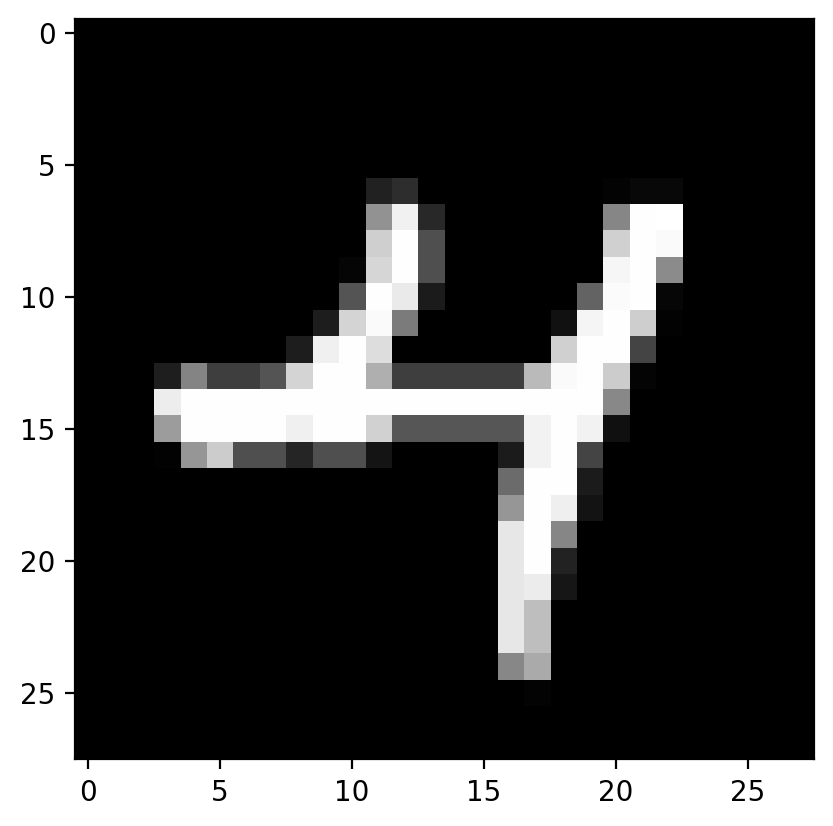

In [ ]:
i = 3
plt.imshow(images[i].numpy().squeeze(), cmap='Greys_r');
print(labels[i])
print(images[1].flatten().shape)
print(torch.flatten(images[0]).shape)
print(images.view(images.shape[0], -1).shape)

## Manual Construction of a Neural Network

Experiment with manually implementation of setting weight matrices and using them for matrix multiplication to compute the prediction. No training is carried out here, this is just to show how the feedforward process is done.

First, let's try to build a simple network for this dataset using weight matrices and matrix multiplications. Then, we'll see how to do it using PyTorch's `nn` module which provides a much more convenient and powerful method for defining network architectures.

The networks you've seen so far are called *fully-connected* or *dense* networks. Each unit in one layer is connected to each unit in the next layer. In fully-connected networks, the input to each layer must be a one-dimensional vector (which can be stacked into a 2D tensor as a batch of multiple examples). However, our images are 28x28 2D tensors, so we need to convert them into 1D vectors. Thinking about sizes, we need to convert the batch of images with shape `(64, 1, 28, 28)` to a have a shape of `(64, 784)`, 784 is 28 times 28. This is typically called *flattening*, we flattened the 2D images into 1D vectors.

Previously you built a network with one output unit. Here we need 10 output units, one for each digit. We want our network to predict the digit shown in an image, so what we'll do is calculate probabilities that the image is of any one digit or class. This ends up being a discrete probability distribution over the classes (digits) that tells us the most likely class for the image. That means we need 10 output units for the 10 classes (digits). We'll see how to convert the network output into a probability distribution next.

> **Exercise:** Flatten the batch of images `images`. Then build a multi-layer network with 784 input units, 128 hidden units, and 10 output units using random tensors for the weights and biases. For now, use a sigmoid activation for the hidden layer. Leave the output layer without an activation, we'll add one that gives us a probability distribution next.

In [ ]:
## Your solution
torch.manual_seed(7) # Set the random seed so things are predictable

# Define the size of each layer in our network
n_input = 28*28      # Number of input units, must match number of input features
n_hidden = 128       # Number of hidden units 
n_output = 10        # Number of output units

# Weights for inputs to hidden layer
W1 = torch.randn(n_input, n_hidden)
# Weights for hidden layer to output layer
W2 = torch.randn(n_hidden, n_output)

# and bias terms for hidden and output layers
B1 = torch.randn((1, n_hidden))
B2 = torch.randn((1, n_output))

def activation(x):
    return 1/(1+torch.exp(-x))

#Calculate the output of this network using matrix multiplication
def output(features, weights, bias): 
    x = torch.mm(features, weights) + bias 
    return activation(x)

# we need a 64x784 matrix from the original 64x1x28x28 Tensor
# images.view(rows, cols)
# rows = first dimension of images which is images.shape[0]
# cols = unkown-->flatten, which is -1
images_flatten = images.view(images.shape[0], -1) 
h = output(images_flatten, W1, B1)
print (h.shape)
out = output(h, W2, B2)
print (out.shape)
print (torch.exp(out).shape)
print (torch.sum(torch.exp(out), dim=1).shape)

#out = # output of your network, should have shape (64,10)

torch.Size([64, 128])
torch.Size([64, 10])
torch.Size([64, 10])
torch.Size([64])


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to. 

To calculate this probability distribution, we often use the [**softmax** function](https://en.wikipedia.org/wiki/Softmax_function). Mathematically this looks like

$$
\Large \sigma(x_i) = \cfrac{e^{x_i}}{\sum_k^n{e^{x_k}}}
$$

What this does is squish each input $x_i$ between 0 and 1 and normalizes the values to give you a proper probability distribution where the probabilites sum up to one.

> **Example:** Implement a function `softmax` that performs the softmax calculation and returns probability distributions for each example in the batch. Note that you'll need to pay attention to the shapes when doing this. If you have a tensor `a` with shape `(64, 10)` and a tensor `b` with shape `(64,)`, doing `a/b` will give you an error because PyTorch will try to do the division across the columns (called broadcasting) but you'll get a size mismatch. The way to think about this is for each of the 64 examples, you only want to divide by one value, the sum in the denominator. So you need `b` to have a shape of `(64, 1)`. This way PyTorch will divide the 10 values in each row of `a` by the one value in each row of `b`. Pay attention to how you take the sum as well. You'll need to define the `dim` keyword in `torch.sum`. Setting `dim=0` takes the sum across the rows while `dim=1` takes the sum across the columns.

In [ ]:
def softmax(x):
    # dim=1 for sum of cols (sum per row)
    # view() to flip from 1x64 to 64x1
    return torch.exp(x) / torch.sum(torch.exp(x), dim=1).view(-1,1)
    

# Here, out should be the output of the network in the previous excercise with shape (64,10)
probabilities = softmax(out)

# Does it have the right shape? Should be (64, 10)
print(probabilities.shape)
# Does it sum to 1?
print(probabilities.sum(dim=1).shape)
print(probabilities.sum(dim=1))

torch.Size([64, 10])
torch.Size([64])
tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])


## Building Neural Networks with PyTorch

PyTorch provides a module `nn` that makes building networks much simpler. Here as an example, let's build the same one as above with 784 inputs, 128 hidden units, 10 output units and a softmax output.

In [ ]:
from torch import nn

In [ ]:
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 128)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(128, 10)
        
        # Define sigmoid activation and softmax output 
        self.sigmoid = nn.Sigmoid()
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        # Pass the input tensor through each of our operations
        x = self.hidden(x)
        x = self.sigmoid(x)
        x = self.output(x)
        x = self.softmax(x)
        
        return x

Let's go through this bit by bit.

```python
class Network(nn.Module):
```

Here we're inheriting from `nn.Module`. Combined with `super().__init__()` this creates a class that tracks the architecture and provides a lot of useful methods and attributes. It is mandatory to inherit from `nn.Module` when you're creating a class for your network. The name of the class itself can be anything.

```python
self.hidden = nn.Linear(784, 128)
```

This line creates a module for a linear transformation, $x\mathbf{W} + b$, with 784 inputs and 128 outputs and assigns it to `self.hidden`. The module automatically creates the weight and bias tensors which we'll use in the `forward` method. You can access the weight and bias tensors once the network (`net`) is created with `net.hidden.weight` and `net.hidden.bias`.

```python
self.output = nn.Linear(128, 10)
```

Similarly, this creates another linear transformation with 128 inputs and 10 outputs.

```python
self.sigmoid = nn.Sigmoid()
self.softmax = nn.Softmax(dim=1)
```

Here I defined operations for the sigmoid activation and softmax output. Setting `dim=1` in `nn.Softmax(dim=1)` calculates softmax across the columns.

```python
def forward(self, x):
```

PyTorch networks created with `nn.Module` must have a `forward` method defined. It takes in a tensor `x` and passes it through the operations you defined in the `__init__` method.

```python
x = self.hidden(x)
x = self.sigmoid(x)
x = self.output(x)
x = self.softmax(x)
```

Here the input tensor `x` is passed through each operation and reassigned to `x`. We can see that the input tensor goes through the hidden layer, then a sigmoid function, then the output layer, and finally the softmax function. It doesn't matter what you name the variables here, as long as the inputs and outputs of the operations match the network architecture you want to build. The order in which you define things in the `__init__` method doesn't matter, but you'll need to sequence the operations correctly in the `forward` method.

Now we can create a `Network` object.

In [ ]:
# Create the network and look at it's text representation
model = Network()
model

Network(
  (hidden): Linear(in_features=784, out_features=128, bias=True)
  (output): Linear(in_features=128, out_features=10, bias=True)
  (sigmoid): Sigmoid()
  (softmax): Softmax(dim=1)
)

You can define the network somewhat more concisely and clearly using the `torch.nn.functional` module. This is the most common way you'll see networks defined as many operations are simple element-wise functions. We normally import this module as `F`, `import torch.nn.functional as F`.

In [ ]:
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.hidden = nn.Linear(784, 128)
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(128, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.sigmoid(self.hidden(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x

## Your Turn to Build a Network

<img src="assets/mlp_mnist.png" width=600px>

> **Example:** Create a network with 784 input units, a hidden layer with 128 units and a ReLU activation, then a hidden layer with 64 units and a ReLU activation, and finally an output layer with a softmax activation as shown above. You can use a ReLU activation with the `nn.ReLU` module or `F.relu` function.

It's good practice to name your layers by their type of network, for instance 'fc' to represent a fully-connected layer. As you code your solution, use `fc1`, `fc2`, and `fc3` as your layer names.

In [ ]:
## Your solution here
import torch.nn.functional as F

class Network(nn.Module):
    def __init__(self):
        super().__init__()
        # Inputs to hidden layer linear transformation
        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 64)
    
        # Output layer, 10 units - one for each digit
        self.output = nn.Linear(64, 10)
        
    def forward(self, x):
        # Hidden layer with sigmoid activation
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        # Output layer with softmax activation
        x = F.softmax(self.output(x), dim=1)
        
        return x


### Initializing weights and biases

The weights and such are automatically initialized for you, but it's possible to customize how they are initialized. The weights and biases are tensors attached to the layer you defined, you can get them with `model.fc1.weight` for instance.

In [ ]:
model = Network()
print(model.fc1.weight)
print(model.fc1.bias)

Parameter containing:
tensor([[-0.0180,  0.0173,  0.0250,  ...,  0.0134, -0.0239,  0.0161],
        [ 0.0328, -0.0268, -0.0168,  ..., -0.0035,  0.0352,  0.0261],
        [-0.0098,  0.0146,  0.0276,  ...,  0.0118, -0.0286, -0.0042],
        ...,
        [ 0.0054,  0.0009,  0.0246,  ..., -0.0043, -0.0144, -0.0336],
        [-0.0014,  0.0083, -0.0251,  ...,  0.0181,  0.0200,  0.0354],
        [ 0.0088,  0.0099,  0.0192,  ..., -0.0148, -0.0243, -0.0299]],
       requires_grad=True)
Parameter containing:
tensor([ 0.0299,  0.0338, -0.0186,  0.0222, -0.0305, -0.0152, -0.0070, -0.0117,
        -0.0019,  0.0036, -0.0084,  0.0340, -0.0075, -0.0303, -0.0160, -0.0313,
         0.0194,  0.0013,  0.0336, -0.0048,  0.0238, -0.0303,  0.0020,  0.0088,
        -0.0289,  0.0308,  0.0061, -0.0162,  0.0313,  0.0208,  0.0323, -0.0276,
        -0.0059, -0.0044,  0.0304, -0.0246,  0.0104,  0.0065,  0.0301,  0.0106,
        -0.0293, -0.0130, -0.0125,  0.0344,  0.0063,  0.0027, -0.0290, -0.0088,
         0.0100

For custom initialization, we want to modify these tensors in place. These are actually autograd *Variables*, so we need to get back the actual tensors with `model.fc1.weight.data`. Once we have the tensors, we can fill them with zeros (for biases) or random normal values.

In [ ]:
# Set biases to all zeros
model.fc1.bias.data.fill_(0)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
# sample from random normal with standard dev = 0.01
model.fc1.weight.data.normal_(std=0.01)

tensor([[ 0.0061, -0.0054, -0.0116,  ...,  0.0125, -0.0085,  0.0050],
        [-0.0057,  0.0117,  0.0041,  ..., -0.0006,  0.0037,  0.0004],
        [-0.0065, -0.0217,  0.0038,  ..., -0.0048,  0.0129, -0.0062],
        ...,
        [-0.0092, -0.0178,  0.0018,  ...,  0.0087, -0.0046, -0.0039],
        [-0.0194,  0.0090, -0.0016,  ...,  0.0019,  0.0079, -0.0080],
        [ 0.0129,  0.0060,  0.0002,  ..., -0.0199,  0.0036, -0.0040]])

### Feed-Forward Process

Now that we have a network, let's see what happens when we pass in an image.

In [ ]:
# Grab some data 
dataiter = iter(trainloader)
#images, labels = dataiter.next()  # older version
images, labels = dataiter.__next__()

# Resize images into a 1D vector, new shape is (batch size, color channels, image pixels) 
images.resize_(64, 1, 784)
# or images.resize_(images.shape[0], 1, 784) to automatically get batch size
# we used a different way to flatten it earlier

# Forward pass through the network
img_idx = 5
ps = model.forward(images[img_idx,:])
print(images[img_idx,:].shape)

img = images[img_idx]
# helper.view_classify(img.view(1, 28, 28), ps)

torch.Size([1, 784])


Now we have 10 outputs for our network. We want to pass in an image to our network and get out a probability distribution over the classes that tells us the likely class(es) the image belongs to. 

**Your Task:** Develop a helper function to visualize the probability distirubtion. Something that looks like this:
<img src='assets/image_distribution.png' width=500px>

As you can see above, our network has basically no idea what this digit is. It's because we haven't trained it yet, all the weights are random!

### Using `nn.Sequential`

PyTorch provides a convenient way to build networks like this where a tensor is passed sequentially through operations, `nn.Sequential` ([documentation](https://pytorch.org/docs/master/nn.html#torch.nn.Sequential)). Using this to build the equivalent network:

In [ ]:
# Hyperparameters for our network
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

# Build a feed-forward network
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      nn.Softmax(dim=1))
print(model)

# Forward pass through the network and display output
images, labels = next(iter(trainloader))
images.resize_(images.shape[0], 1, 784)
ps = model.forward(images[0,:])
#helper.view_classify(images[0].view(1, 28, 28), ps)

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Softmax(dim=1)
)


Here our model is the same as before: 784 input units, a hidden layer with 128 units, ReLU activation, 64 unit hidden layer, another ReLU, then the output layer with 10 units, and the softmax output.

The operations are available by passing in the appropriate index. For example, if you want to get first Linear operation and look at the weights, you'd use `model[0]`.

Again because we haven't trained neural net yet, all the weights are random, so the class probabilities are evenly distributed!

In [ ]:
print(model[0])
model[0].weight

Linear(in_features=784, out_features=128, bias=True)


Parameter containing:
tensor([[ 0.0042,  0.0027, -0.0301,  ...,  0.0282,  0.0343, -0.0172],
        [ 0.0265, -0.0013, -0.0271,  ...,  0.0026,  0.0028,  0.0239],
        [ 0.0078, -0.0018, -0.0112,  ...,  0.0093,  0.0113, -0.0120],
        ...,
        [-0.0081,  0.0334, -0.0008,  ..., -0.0031, -0.0311, -0.0041],
        [-0.0038,  0.0065, -0.0241,  ...,  0.0196,  0.0194,  0.0010],
        [ 0.0014,  0.0032, -0.0095,  ..., -0.0212, -0.0354,  0.0336]],
       requires_grad=True)

You can also pass in an `OrderedDict` to name the individual layers and operations, instead of using incremental integers. Note that dictionary keys must be unique, so _each operation must have a different name_.

In [ ]:
from collections import OrderedDict
model = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('output', nn.Linear(hidden_sizes[1], output_size)),
                      ('softmax', nn.Softmax(dim=1))]))
model

Sequential(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (relu2): ReLU()
  (output): Linear(in_features=64, out_features=10, bias=True)
  (softmax): Softmax(dim=1)
)

Now you can access layers either by integer or the name

In [ ]:
print(model[0])
print(model.fc1)

Linear(in_features=784, out_features=128, bias=True)
Linear(in_features=784, out_features=128, bias=True)


In the next notebook TrainingNN, we'll see how we can train a neural network to accuractly predict the numbers appearing in the MNIST images.